In [31]:
import numpy as np  # always need it
import matplotlib.pyplot as plot
import skimage
import ot  # ot
import pandas as pd

In [45]:
df = pd.read_csv("/Users/andrewrodriguez/Desktop/Files/OT_Testing/sample_data.csv")
df["x"] = ((df["x"] * 5 + 1) * 5) 
df["y"] = ((df["y"] * 5 + 1) * 5) 
df = df[["x", "y", "t_ind"]]

In [46]:
df.head()

,x,y,t_ind
0,5.230620,4.494279,0
1,5.434450,5.331633,0
2,4.770843,5.429729,0
3,5.212548,5.377415,0
4,5.133066,5.385476,0


In [47]:
time_set = []

for time in df["t_ind"].unique():
    this_time = df[df["t_ind"] == time]
    coords = this_time[['x', 'y']].values
    time_set.append(coords)

In [48]:
map_dim = 10
time_maps = []

for set in time_set:
    density_map = np.zeros((map_dim, map_dim))
    cell_coords = np.int64(set)
    current_cells = cell_coords
    n_cells = current_cells.shape[0]
    prop = np.ones(n_cells)  # just cell density

        
    # Populate the map with cell densities
    for idx in range(n_cells):
        density_map[cell_coords[idx, 1], cell_coords[idx, 0]] += prop[idx]

    sigma_pix = 2
    density_map = skimage.filters.gaussian(density_map, sigma=sigma_pix, truncate=1) 

    time_maps.append(density_map)


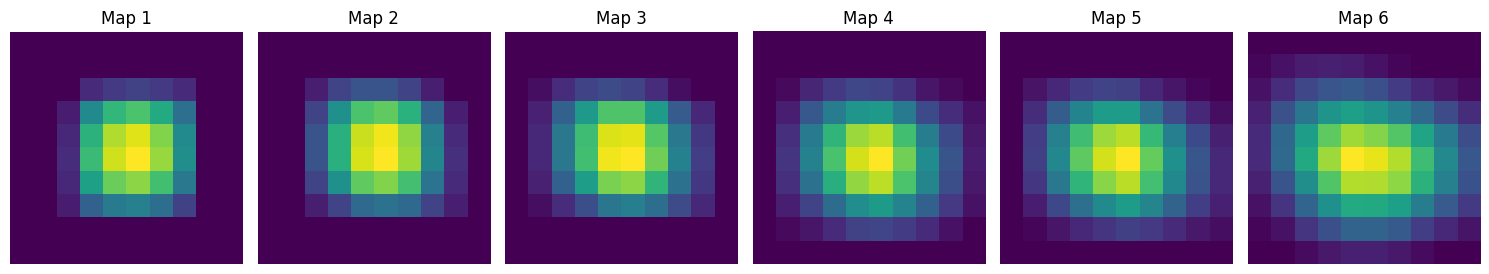

In [49]:
fig, axes = plot.subplots(1, len(time_maps), figsize=(15, 5))  # Adjust figsize as needed

for i, (ax, map) in enumerate(zip(axes, time_maps)):
    ax.imshow(map.T)
    ax.set_title(f'Map {i+1}')  # Set label for each subplot
    ax.axis('off')  # Turn off axis if not needed

plot.tight_layout()
plot.show()

In [50]:
points = []

for i in range(map_dim):
    for j in range(map_dim):
        points.append([i,j])

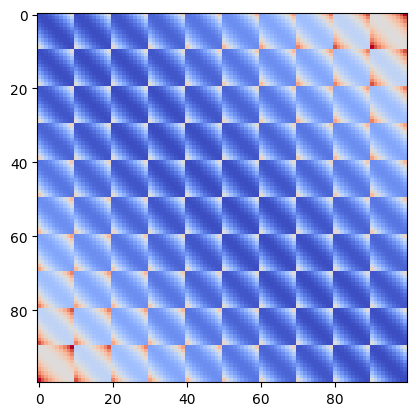

In [51]:
C = ot.dist(np.array(points), np.array(points))


im = plot.imshow(C, cmap="coolwarm")


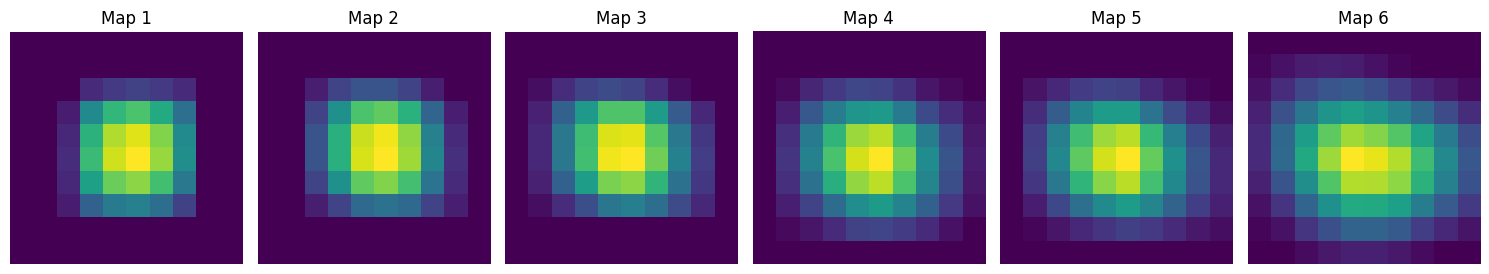

In [53]:
fig, axes = plot.subplots(1, len(time_maps), figsize=(15, 5))  # Adjust figsize as needed

for i, (ax, map) in enumerate(zip(axes, time_maps)):
    ax.imshow(map.T)
    ax.set_title(f'Map {i+1}')  # Set label for each subplot
    ax.axis('off')  # Turn off axis if not needed

plot.tight_layout()
plot.show()

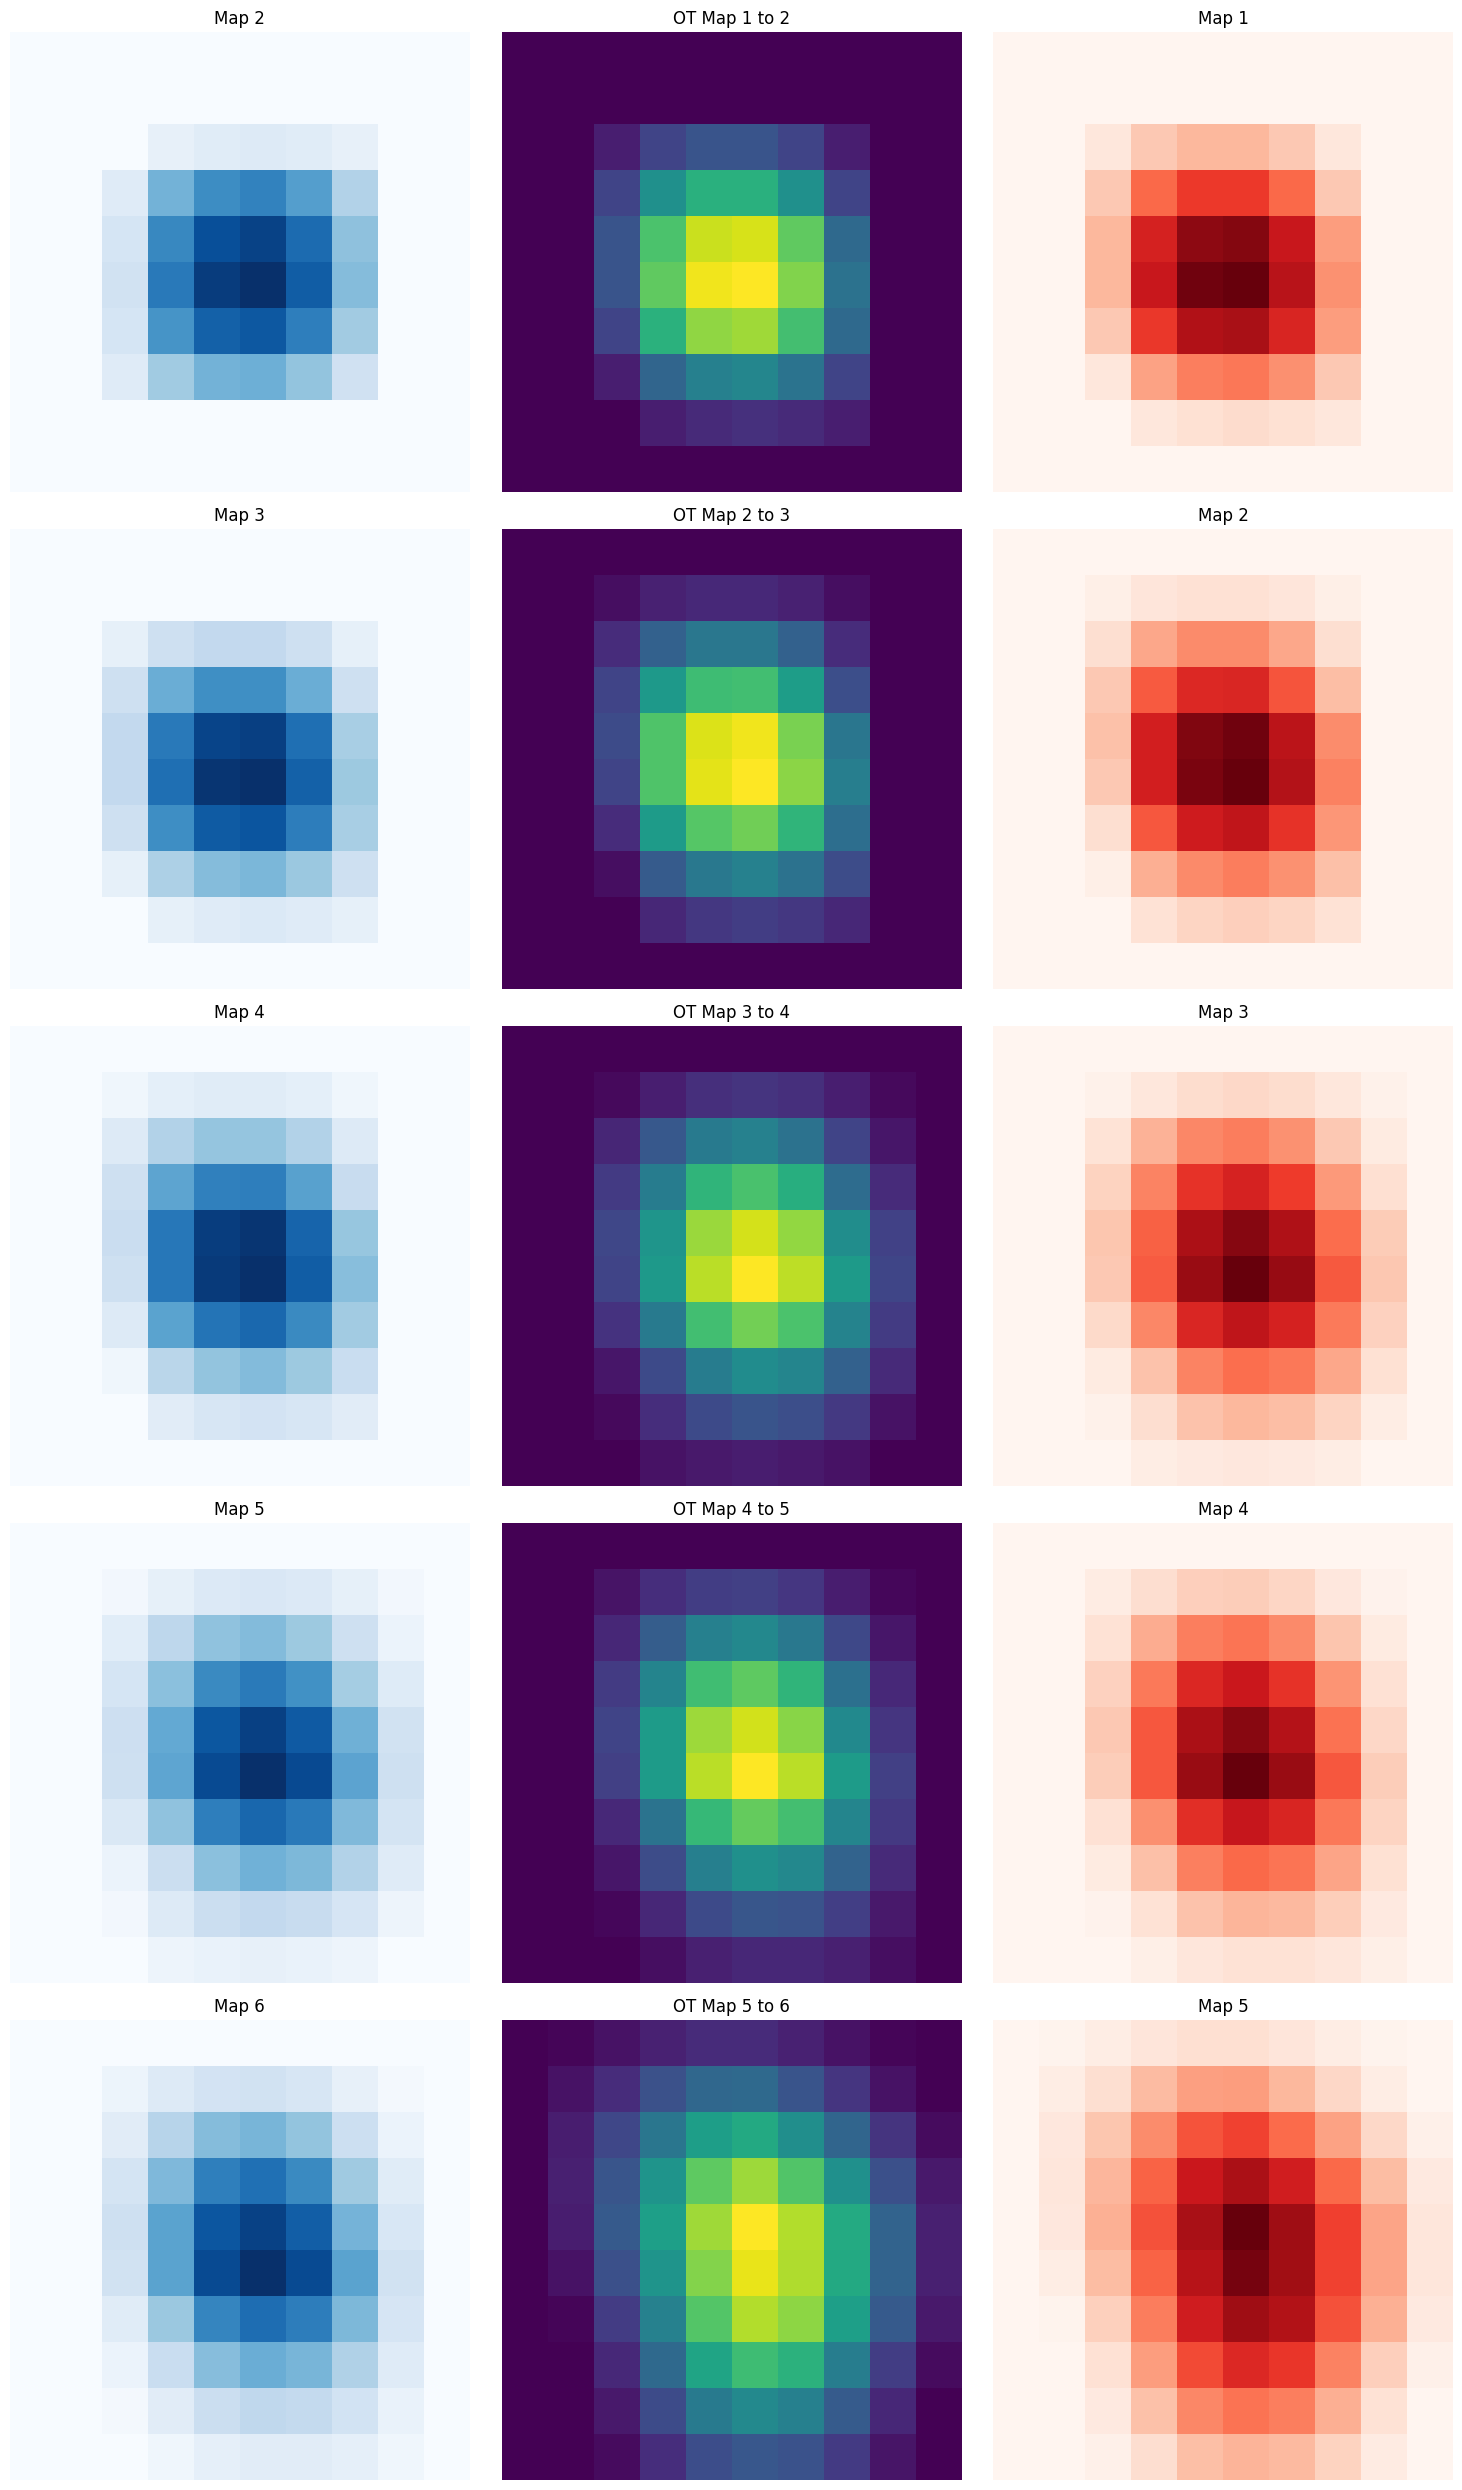

In [54]:
import numpy as np
import ot
import matplotlib.pyplot as plt

# Sample time_maps (replace with your actual data)
# Create a figure with subplots arranged side by side
fig, axes = plt.subplots(len(time_maps) - 1, 3, figsize=(15, 5 * (len(time_maps) - 1)))

for i in range(len(time_maps) - 1):
    map1 = time_maps[i+1].astype(np.float64)  # Convert to float64 for OT computation
    map2 = time_maps[i].astype(np.float64)

    # Flatten the maps to 1D arrays
    map1_flat = map1.flatten()
    map2_flat = map2.flatten()

    reg = 0.005
    K = np.exp(-C / C.max() / reg)
    nit = 100


    u = np.ones(len(map1_flat), )
    for j in range(1, nit):
        v = map2_flat / np.dot(K.T, u)
        u = map1_flat / (np.dot(K, v))
    ot_sink_algo = np.atleast_2d(u).T * (K * v.T)  # Equivalent to np.dot(np.diag(u), np.dot(K, np.diag(v)))


    nx, ny = map1.shape
    X, Y = np.meshgrid(np.arange(nx), np.arange(ny))
    pos = np.vstack([X.ravel(), Y.ravel()]).T
    cost_matrix = ot.dist(pos, pos)

    # Reshape the OT matrix back to the original map shape
    ot_map = ot_sink_algo.reshape(nx, ny, nx, ny).sum(axis=2).sum(axis=2)

    # Plot the first density map
    ax1 = axes[i, 2]
    im1 = ax1.imshow(map1, cmap='Reds')
    ax1.set_title(f'Map {i+1}')
    ax1.axis('off')

    # Plot the second density map
    ax2 = axes[i, 0]
    im2 = ax2.imshow(map2, cmap='Blues')
    ax2.set_title(f'Map {i+2}')
    ax2.axis('off')

    # Plot the OT map
    ax3 = axes[i, 1]
    im3 = ax3.imshow(ot_map, cmap='viridis')
    ax3.set_title(f'OT Map {i+1} to {i+2}')
    ax3.axis('off')


plt.tight_layout()
plt.show()

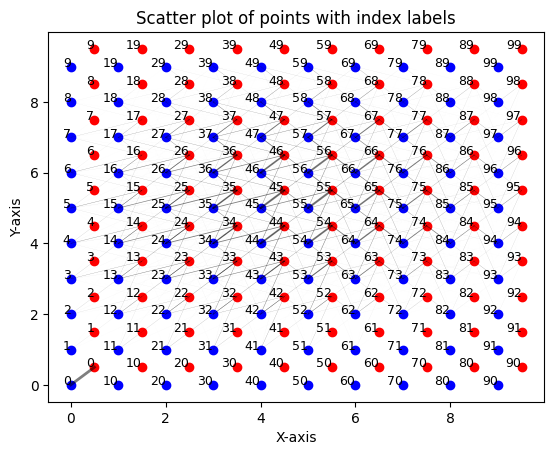

In [67]:
# Create a scatter plot
# Scatter plot for original points (blue)
for i, point in enumerate(points):
    plt.scatter(point[0], point[1], color='blue')
    plt.text(point[0], point[1], str(i), fontsize=9, ha='right')

# Scatter plot for shifted points (red)
shifted_points = [(point[0] + 0.5, point[1] + 0.5) for point in points]
for i, point in enumerate(shifted_points):
    plt.scatter(point[0], point[1], color='red')
    plt.text(point[0], point[1], str(i), fontsize=9, ha='right')



# Draw lines representing OT transport
for i in range(len(points)):
    for j in range(len(shifted_points)):
        if ot_sink_algo[i, j] > 0:
            plt.plot([points[i][0], shifted_points[j][0]], [points[i][1], shifted_points[j][1]], 'k-', alpha=0.5, lw = 2 * ot_sink_algo[i, j])


# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter plot of points with index labels')

plt.show()